In [1]:
import json

import utils

data_path = r"C:\Users\gac8\PycharmProjects\PSSearch\Gian_experimental\operator_data_collection\compare_methods05-14-H10'm'11's58.json"

with open(data_path, "r") as file:
    data = json.load(file)


results_by_method = data["results"]



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def compare_distributions_histogram(
    datasets,
    bin_count=50,
    xlim=None,
    labels=None,
    title="Histogram Comparison",
    density=False,
    alpha=0.8,
    colors=None,
    logx=False,
    logy=False
):
    """
    Compare multiple distributions using side-by-side histograms.

    Parameters:
    - datasets: List of lists or arrays of numbers
    - bin_count: Number of bins to use (even for log scale)
    - xlim: Tuple (xmin, xmax) for x-axis limits; if None, auto-calculated
    - labels: List of labels for each dataset
    - title: Title of the plot
    - density: If True, plot probability densities instead of counts
    - alpha: Transparency of the histogram bars
    - colors: List of colors for the histograms
    - logx: If True, set x-axis to log scale (requires positive data)
    - logy: If True, set y-axis to log scale
    """
    datasets = [np.asarray(data) for data in datasets]
    
    if logx:
        datasets = [data[data > 0] for data in datasets]

    # Determine x-axis limits
    if xlim is None:
        xmin = min(data.min() for data in datasets)
        xmax = max(data.max() for data in datasets)
        xlim = (xmin, xmax)

    # Define bins
    if logx:
        bins = np.logspace(np.log10(xlim[0]), np.log10(xlim[1]), bin_count + 1)
    else:
        bins = np.linspace(xlim[0], xlim[1], bin_count + 1)

    # Histogram counts
    hists = [np.histogram(data, bins=bins, density=density)[0] for data in datasets]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    width = np.diff(bins)

    num_datasets = len(datasets)
    offsets = np.linspace(-0.4, 0.4, num=num_datasets) * width[:, None]

    if labels is None:
        labels = [f"Data {i+1}" for i in range(num_datasets)]

    if colors is None:
        colors = [f"C{i}" for i in range(num_datasets)]

    # Plotting
    plt.figure(figsize=(10, 6))
    for i, hist in enumerate(hists):
        center_shift = offsets[:, i]
        plt.bar(bin_centers + center_shift, hist,
                width=width * (0.8 / num_datasets),
                label=labels[i],
                alpha=alpha,
                color=colors[i % len(colors)],
                edgecolor='black',
                align='center')

    plt.xlabel("Value (log scale)" if logx else "Value")
    plt.ylabel("Density" if density else "Count")
    plt.title(title)

    # Axis scaling
    ax = plt.gca()
    if logx:
        ax.set_xscale("log")
        ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
        ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,
                                                     numticks=100, prune=None))
        ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    else:
        ax.set_xscale("linear")

    if logy:
        ax.set_yscale("log")

    plt.xlim(xlim)
    plt.legend()
    plt.grid(True, which='both' if logx or logy else 'major', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


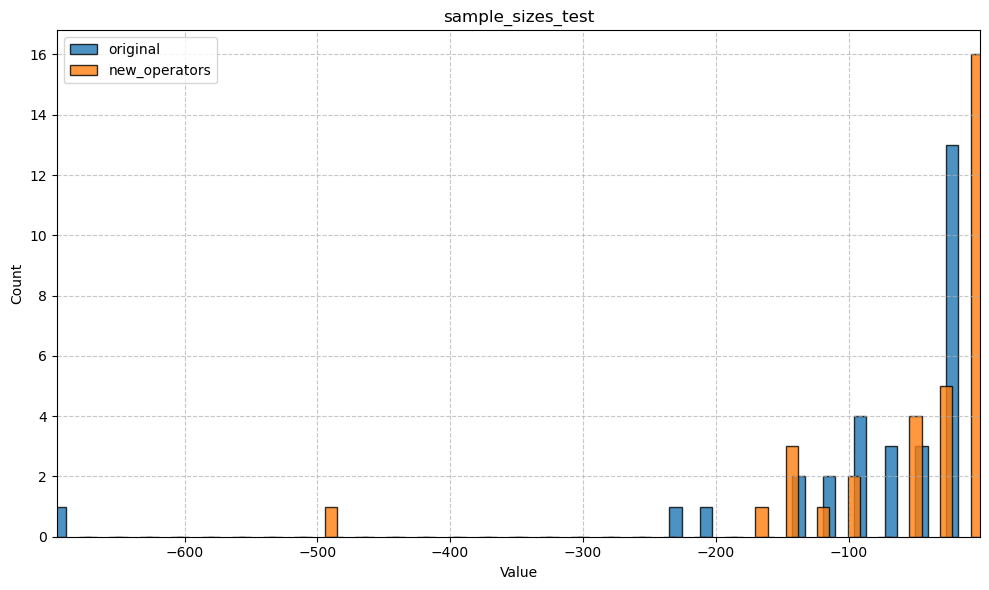

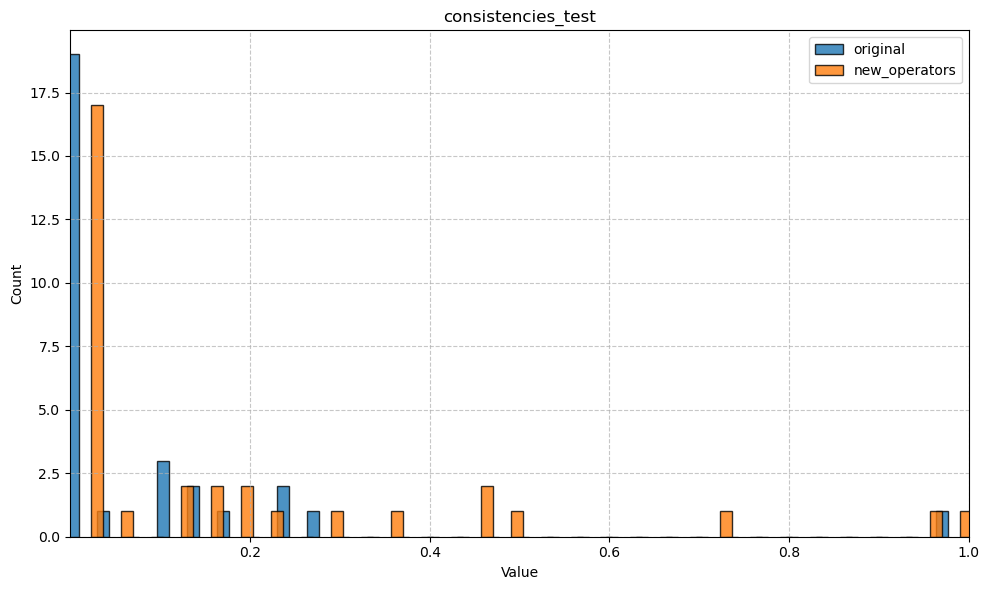

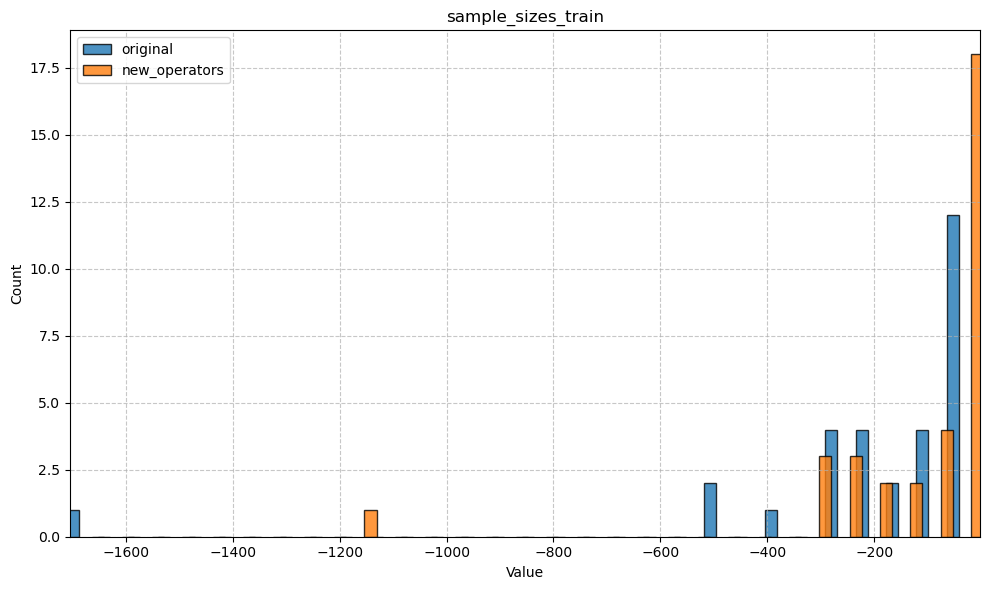

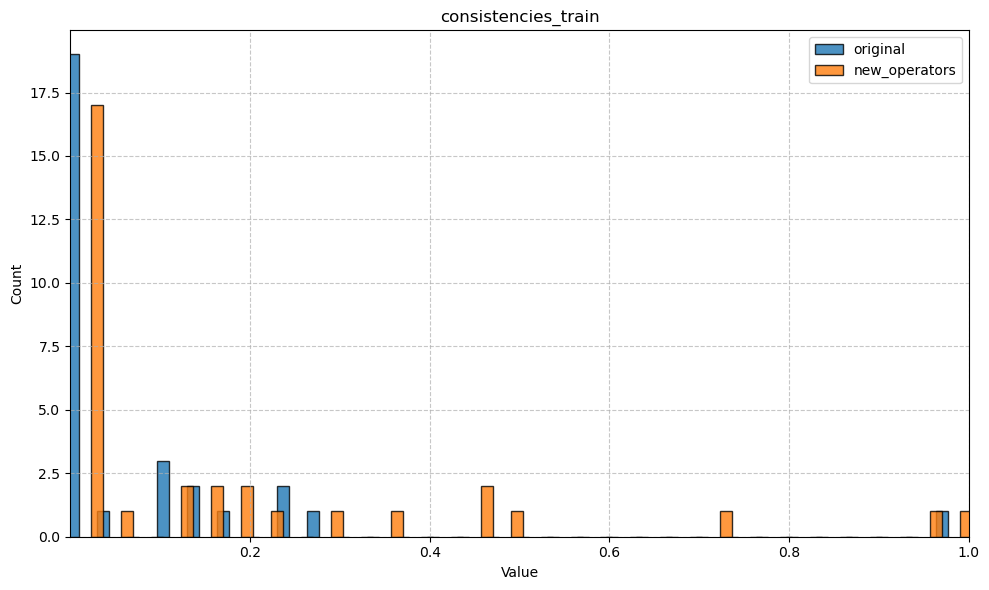

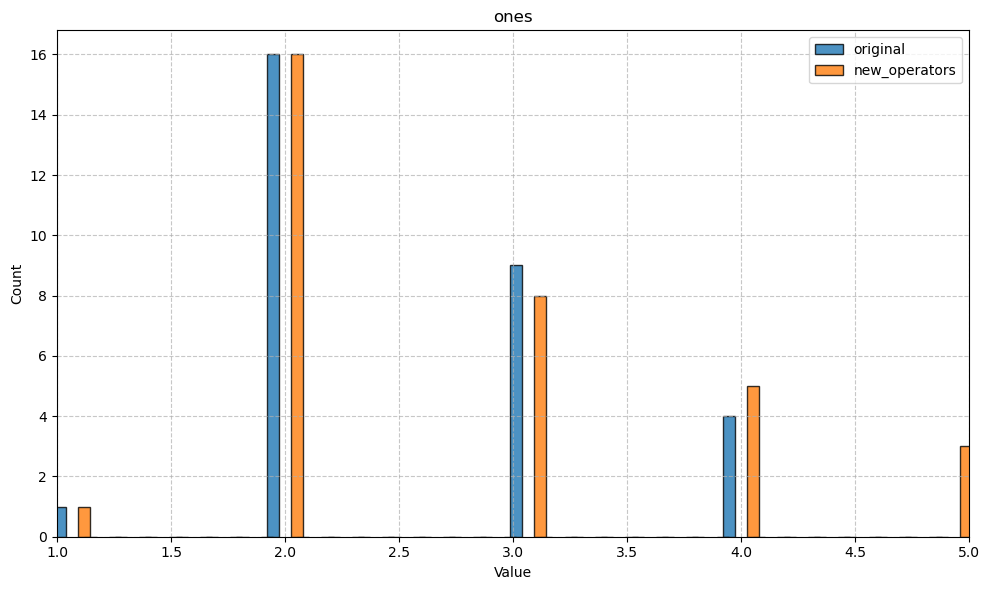

In [3]:
def compare_property(property_name):
    all_categories = [(item["method"], item["run_result"]) for item in results_by_method]
    
    all_lists = [numbers[property_name] for name, numbers in all_categories]
    
    category_names = [name for name, numbers in all_categories]
    
    
    
    compare_distributions_histogram(datasets=all_lists, title=property_name, labels=category_names, bin_count=30)
    
for property_name in ["sample_sizes_test", "consistencies_test", "sample_sizes_train", "consistencies_train", "ones"]:
    compare_property(property_name)

In [4]:
import json
from os.path import isfile
import os
from os import listdir

# the intention is to have the all the result files in one folder, and analyse them together.

main_dir = r"C:\Users\gac8\PycharmProjects\PSSearch\Gian_experimental\operator_data_collection\V2"
files = listdir(main_dir)
files = [os.path.join(main_dir, file) for file in files]
files = [file for file in files if isfile(file) if file.endswith(".json")]


def get_data_for_file(filename):
    with open(filename, "r") as file:
        data = json.load(file)
    return data["results"]


metrics = ["sample_sizes_test", "consistencies_test", "ones"]


def only_significant_pss_in_train(data_for_method):
    is_acceptable = [p_value < 0.05 and ones > 0 for p_value, ones
                     in
                     zip(data_for_method["run_result"]["consistencies_train"], data_for_method["run_result"]["ones"])]

    def filter_by_acceptable(items):
        return [item for item, accept in zip(items, is_acceptable) if accept]

    return {"method": data_for_method["method"],
            "run_result": {metric_name: filter_by_acceptable(items)
                            for metric_name, items in data_for_method["run_result"].items()}
            }


data_for_all_files = [results_for_method #only_significant_pss_in_train(results_for_method)
                      for file in files
                      for results_for_method in get_data_for_file(file)]

all_methods = {results_for_method["method"]
               for results_for_method in data_for_all_files}

aggregated = {method: {metric: []
                       for metric in metrics}
              for method in all_methods}

for data_for_a_method in data_for_all_files:
    method = data_for_a_method["method"]
    for metric in metrics:
        aggregated[method][metric].extend(data_for_a_method["run_result"][metric])
    

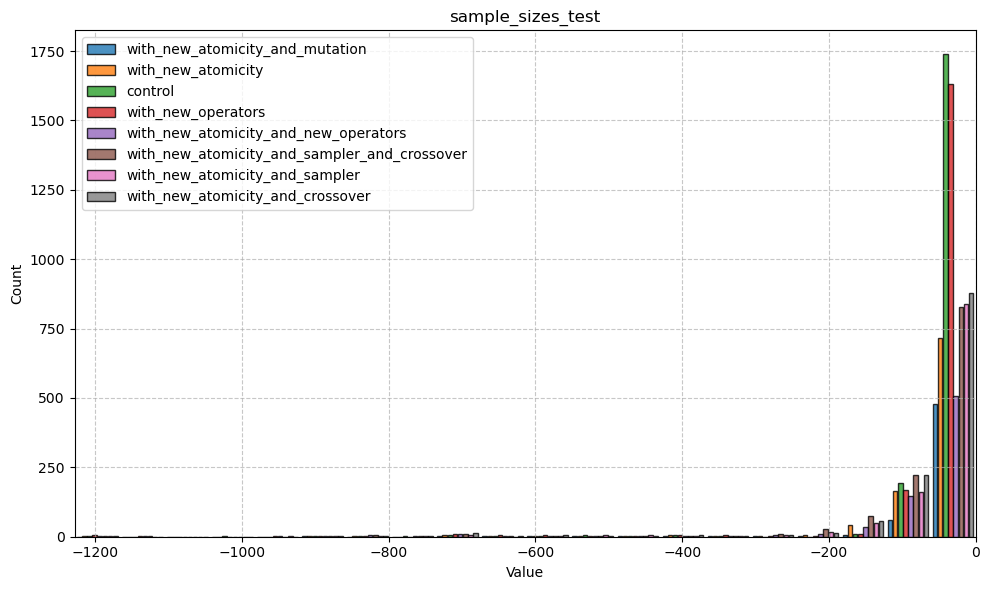

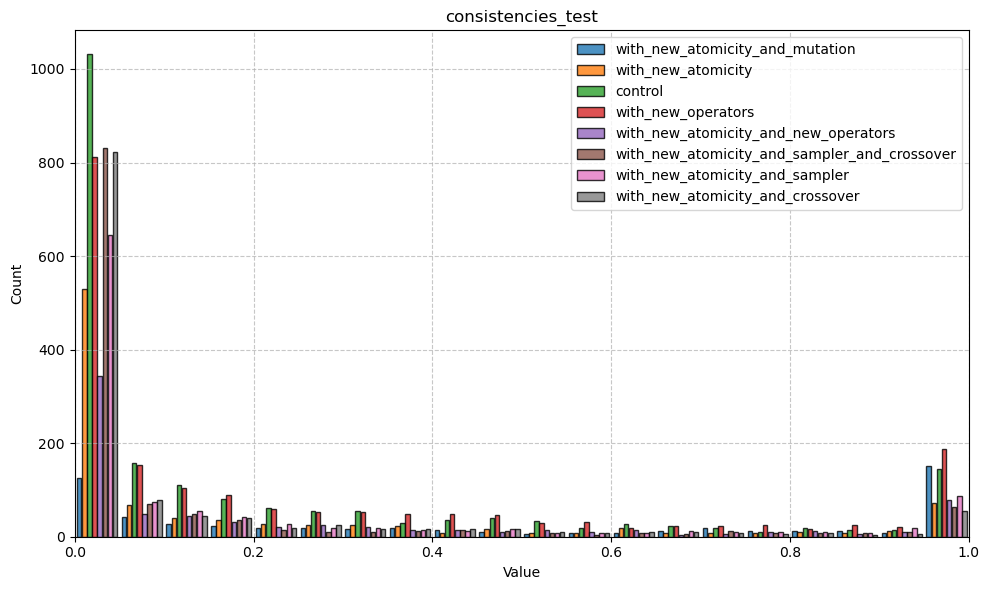

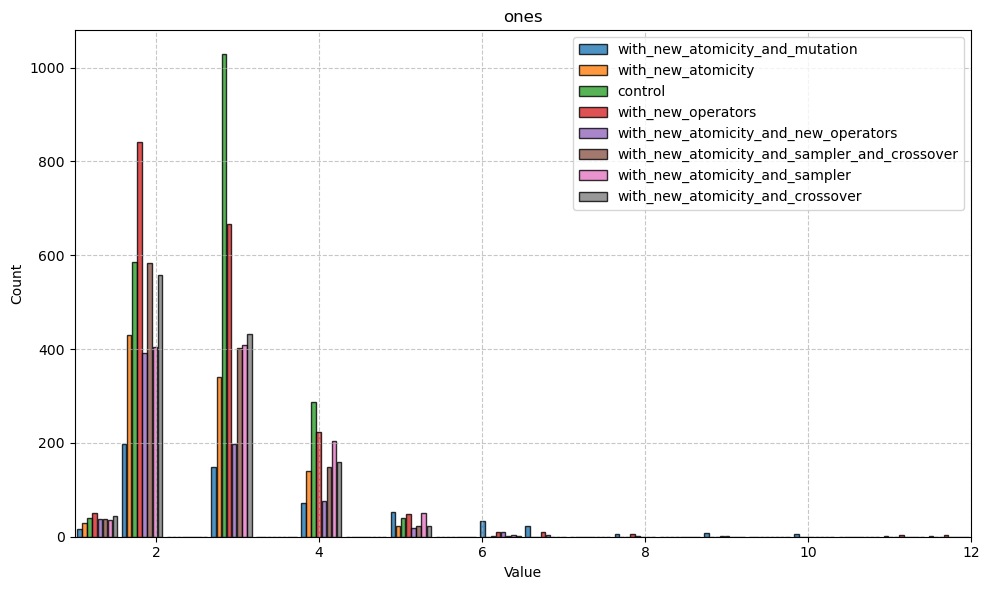

In [5]:
def compare_property_aggregated(property_name):
    all_methods = list(aggregated.keys())
    # 
    all_lists = [aggregated[method][property_name] for method in all_methods]
    
    compare_distributions_histogram(datasets=all_lists, title=property_name, labels=all_methods, bin_count=20)
    
for property_name in ["sample_sizes_test", "consistencies_test", "ones"]:
    compare_property_aggregated(property_name)

In [6]:
proportion_of_good_per_method = {method: np.average(np.array(data["consistencies_test"])<0.05)
                                 for method, data in aggregated.items()}

for method, data in aggregated.items():
    p_values = data["consistencies_test"]
    percentage_of_good = np.average(np.array(p_values) < 0.05)
    print(f"For method {method}, the proportion is {percentage_of_good}")

For method with_new_atomicity_and_mutation, the proportion is 0.22202486678507993
For method with_new_atomicity, the proportion is 0.5509355509355509
For method control, the proportion is 0.5207070707070707
For method with_new_operators, the proportion is 0.43531937734836285
For method with_new_atomicity_and_new_operators, the proportion is 0.46476964769647694
For method with_new_atomicity_and_sampler_and_crossover, the proportion is 0.6948160535117057
For method with_new_atomicity_and_sampler, the proportion is 0.5812274368231047
For method with_new_atomicity_and_crossover, the proportion is 0.6745901639344263


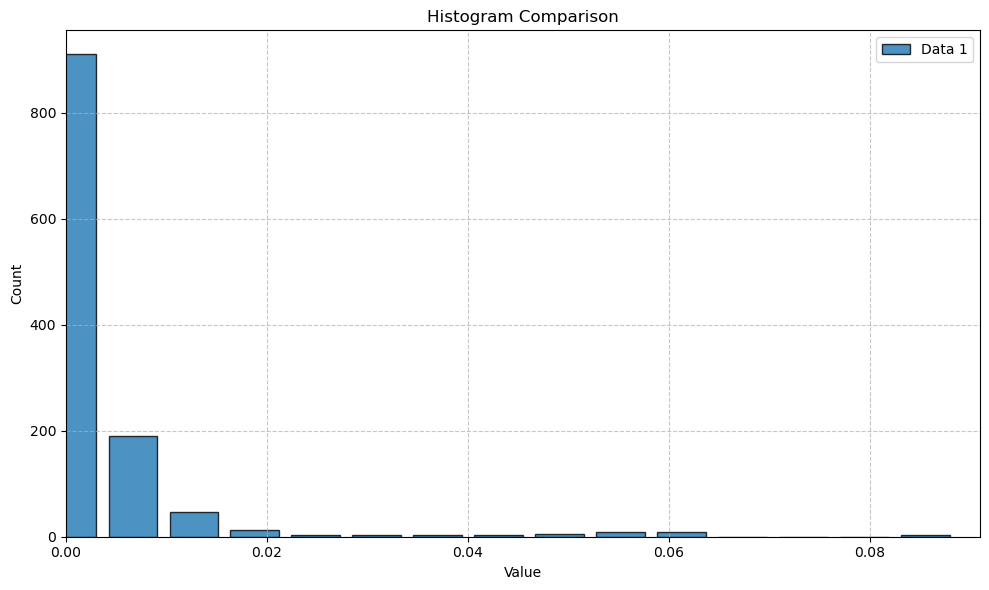

In [7]:
compare_distributions_histogram([-np.array(aggregated["with_new_atomicity_and_sampler_and_crossover"]["sample_sizes_test"])/13000], bin_count=15)

In [8]:
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import gian_get_similarities

data_folder = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting"

# pRef = get_pRef_from_vectors(get_vectors_file_name(data_folder, size, clustering_method),
#                                      get_fitness_file_name(data_folder, size, clustering_method), fitness_column_to_use)

dir_250 = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting\250"
def in_250(path):
    return os.path.join(dir_250, path)
cluster_info_file_name = in_250(f"cluster_info_250_qmc.pkl")

similarities = gian_get_similarities(cluster_info_file_name)

In [9]:
np.sum(similarities - np.min(similarities), axis=1)

array([184.17694, 184.64624, 184.42566, 183.93927, 184.26056, 184.53152,
       184.26523, 184.41464, 184.25955, 184.59468, 183.98103, 184.43497,
       184.32059, 184.32794, 184.50653, 184.1607 , 184.33984, 184.50317,
       184.16278, 184.26071, 184.10245, 184.58594, 184.43634, 184.12411,
       184.65224, 184.21526, 184.53271, 184.     , 183.95975, 184.69766,
       184.06879, 184.54486, 184.1933 , 184.27698, 184.18831, 184.75275,
       184.32219, 184.35751, 184.22928, 184.40846, 184.19524, 184.53809,
       184.284  , 184.15141, 183.95016, 184.41188, 184.17982, 184.72267,
       184.43558, 184.27727, 184.43256, 184.33003, 184.39319, 184.28473,
       184.41458, 184.13388, 184.05556, 184.45166, 184.40378, 184.3556 ,
       184.42564, 183.98547, 184.44556, 184.27467, 184.28867, 184.51102,
       184.20248, 184.34976, 184.39224, 184.5221 , 184.15361, 184.4079 ,
       184.31378, 184.5543 , 184.24786, 184.22601, 184.36111, 184.39508,
       184.2684 , 184.2521 , 183.95616, 184.55173, 